
# Mini Project 4 — **Barrier Options** (Easy, Monte Carlo)

This project explores **exotic options**: **barrier options**.  

- Simulate **GBM** under the risk-neutral measure and **price barrier options** by **Monte Carlo** with discrete monitoring.
- Handle **up**/**down** barriers and **knock-in**/**knock-out** types (European payoff).
- Use **parity** $$\text{Vanilla} = \text{Knock-In} + \text{Knock-Out}$$ to cross-check prices.
- Visualize **convergence** vs steps and vs paths.



## 1) Background and notation

Under the risk-neutral measure,

$$
dS_t \;=\; S_t \,\big((r-q)\,dt + \sigma\,dW_t\big)\,.
$$

Barrier options depend on whether the price path **crosses a level $ H $** before maturity $ T $.  
We consider **discrete monitoring** at equally spaced times $ t_i = i\Delta t $ with $ \Delta t = T/N $.

- **Up barrier:** the option activates (knock-in) or kills (knock-out) if $ \max_i S_{t_i} \ge H $.  
- **Down barrier:** activates or kills if $\min_i S_{t_i} \le H $.

European payoff at $ T $:

$$
\text{Call payoff} = \max(S_T - K,\,0), \qquad
\text{Put payoff}  = \max(K - S_T,\,0).
$$

Knock-in/out **parity** (for the same $ (S_0,K,H,T,r,q,\sigma) $:

$$
\text{Vanilla} \;=\; \text{Knock-In} \;+\; \text{Knock-Out}\,.
$$



## 2) Setup


In [4]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
np.random.seed(10)

# Standard normal CDF via erf
from math import erf
def Phi(x):
    return 0.5*(1.0 + erf(x / math.sqrt(2.0)))



## 3) Vanilla European price (Black–Scholes baseline)

We use the Black–Scholes formula to obtain a **vanilla** reference price (no barrier).

$$
d_1 \;=\; \frac{\ln(S_0/K) + (r - q + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}, \qquad
d_2 \;=\; d_1 - \sigma\sqrt{T}\,.
$$

$$
C \;=\; S_0 e^{-qT}\Phi(d_1) - K e^{-rT}\Phi(d_2), \qquad
P \;=\; K e^{-rT}\Phi(-d_2) - S_0 e^{-qT}\Phi(-d_1)\,.
$$


In [2]:

def bs_price(S, K, r, q, sigma, T, is_call=True):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        if is_call:
            return max(0.0, S*math.exp(-q*T) - K*math.exp(-r*T))
        else:
            return max(0.0, K*math.exp(-r*T) - S*math.exp(-q*T))
    d1 = (math.log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if is_call:
        return S*math.exp(-q*T)*Phi(d1) - K*math.exp(-r*T)*Phi(d2)
    else:
        return K*math.exp(-r*T)*Phi(-d2) - S*math.exp(-q*T)*Phi(-d1)



## 4) Barrier options by Monte Carlo (discrete monitoring)

We simulate \( M \) GBM paths with \( N \) steps. For each path, test barrier crossing:

- **Up barrier**: crossed if \( \max_i S_{t_i} \ge H \).  
- **Down barrier**: crossed if \( \min_i S_{t_i} \le H \).

Pricing with discounting:

$$
\text{Knock-Out}:\quad V \approx e^{-rT}\cdot \frac{1}{M}\sum_{m=1}^M \mathbf{1}\{\text{no hit}\}\cdot \text{Payoff}(S_T^{(m)})\,,
$$

$$
\text{Knock-In}:\quad V \approx e^{-rT}\cdot \frac{1}{M}\sum_{m=1}^M \mathbf{1}\{\text{hit}\}\cdot \text{Payoff}(S_T^{(m)})\,.
$$

**Note:** Discrete monitoring **underprices knock-outs** and **overprices knock-ins** vs true continuous monitoring. Increasing \( N \) reduces the bias.


In [5]:

def simulate_gbm_paths(S0, r, q, sigma, T, N_steps, M_paths, seed=123):
    np.random.seed(seed)
    dt = T / N_steps
    Z = np.random.normal(size=(M_paths, N_steps))
    S = np.empty((M_paths, N_steps+1))
    S[:, 0] = S0
    drift = (r - q - 0.5*sigma*sigma) * dt
    vol   = sigma * math.sqrt(dt)
    for t in range(1, N_steps+1):
        S[:, t] = S[:, t-1] * np.exp(drift + vol*Z[:, t-1])
    return S  # shape (M_paths, N_steps+1)

def barrier_option_mc(S0, K, r, q, sigma, T, N_steps, M_paths, 
                      is_call=True, barrier_type="up", H=120.0, knock="out", seed=123):
    S = simulate_gbm_paths(S0, r, q, sigma, T, N_steps, M_paths, seed=seed)
    ST = S[:, -1]
    if barrier_type == "up":
        hit = (np.max(S, axis=1) >= H)
    else:
        hit = (np.min(S, axis=1) <= H)

    if is_call:
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)

    if knock == "out":
        payoff = payoff * (~hit)
    else:  # knock-in
        payoff = payoff * (hit)

    disc = math.exp(-r*T)
    price = disc * float(np.mean(payoff))
    se    = disc * float(np.std(payoff, ddof=1)/math.sqrt(M_paths))
    return price, se

# Small smoke test
S0, K, r, q, sigma, T = 100.0, 100.0, 0.03, 0.00, float(sigma_hat), 1.0
price_ko, se_ko = barrier_option_mc(S0, K, r, q, sigma, T, 252, 20000, True, "up", 130.0, "out", seed=10)
print(f"Up-and-Out Call (H=130) ~ {price_ko:.4f} ± {1.96*se_ko:.4f}")


NameError: name 'sigma_hat' is not defined


## 5) Parity checks and examples

We verify the **knock-in/out parity** numerically:

$$
\text{Vanilla} \;\approx\; \text{Knock-In} \;+\; \text{Knock-Out}\,.
$$

We also see how the barrier level \( H \) influences prices.


Vanilla Call (BS): 9.4134
Up-and-Out Call (H=120.0): 1.3220
Up-and-In  Call (H=120.0): 7.9797
Parity check (Call): KI+KO ≈ 9.3017 vs Vanilla 9.4134
Vanilla Put  (BS): 6.4580
Down-and-Out Put (H=80.0): 1.9141
Down-and-In  Put (H=80.0): 4.5654
Parity check (Put) : KI+KO ≈ 6.4795 vs Vanilla 6.4580


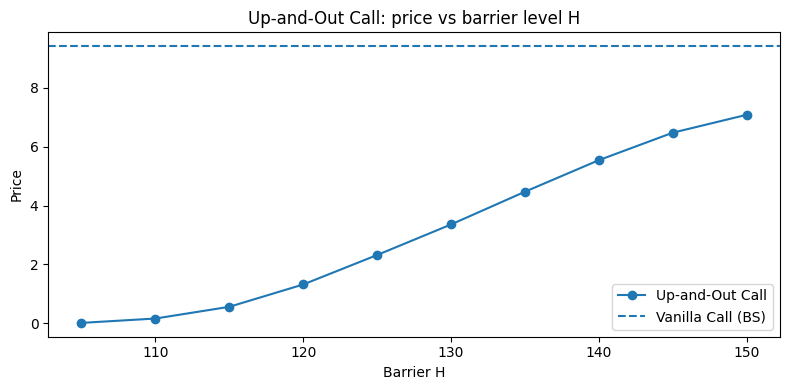

In [6]:
S0, K, r, q, sigma, T = 100.0, 100.0, 0.03, 0.00, 0.2, 1.0
N_steps, M_paths = 252, 30000

# Vanilla
van_call = bs_price(S0, K, r, q, sigma, T, True)
van_put  = bs_price(S0, K, r, q, sigma, T, False)

# Pick an up barrier H > S0
H = 120.0

# Up-and-Out and Up-and-In (call)
uo_call, uo_se = barrier_option_mc(S0, K, r, q, sigma, T, N_steps, M_paths, True, "up", H, "out", seed=5)
ui_call, ui_se = barrier_option_mc(S0, K, r, q, sigma, T, N_steps, M_paths, True, "up", H, "in",  seed=6)

print(f"Vanilla Call (BS): {van_call:.4f}")
print(f"Up-and-Out Call (H={H}): {uo_call:.4f}")
print(f"Up-and-In  Call (H={H}): {ui_call:.4f}")
print(f"Parity check (Call): KI+KO ≈ {ui_call+uo_call:.4f} vs Vanilla {van_call:.4f}")

# Down barrier H < S0
Hd = 80.0
do_put, do_se = barrier_option_mc(S0, K, r, q, sigma, T, N_steps, M_paths, False, "down", Hd, "out", seed=7)
di_put, di_se = barrier_option_mc(S0, K, r, q, sigma, T, N_steps, M_paths, False, "down", Hd, "in",  seed=8)

print(f"Vanilla Put  (BS): {van_put:.4f}")
print(f"Down-and-Out Put (H={Hd}): {do_put:.4f}")
print(f"Down-and-In  Put (H={Hd}): {di_put:.4f}")
print(f"Parity check (Put) : KI+KO ≈ {di_put+do_put:.4f} vs Vanilla {van_put:.4f}")

# Visual: price vs barrier for Up-and-Out call
H_vals = np.linspace(105, 150, 10)
prices = []
for Hv in H_vals:
    pv, _ = barrier_option_mc(S0, K, r, q, sigma, T, N_steps, M_paths//3, True, "up", float(Hv), "out", seed=10)
    prices.append(pv)

plt.figure()
plt.plot(H_vals, prices, marker='o', label="Up-and-Out Call")
plt.axhline(van_call, linestyle='--', label="Vanilla Call (BS)")
plt.title("Up-and-Out Call: price vs barrier level H")
plt.xlabel("Barrier H")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


## 6) Convergence demos (steps and paths)

- **Increase steps \( N \)** to reduce discrete monitoring bias.  
- **Increase paths \( M \)** to reduce MC standard error.


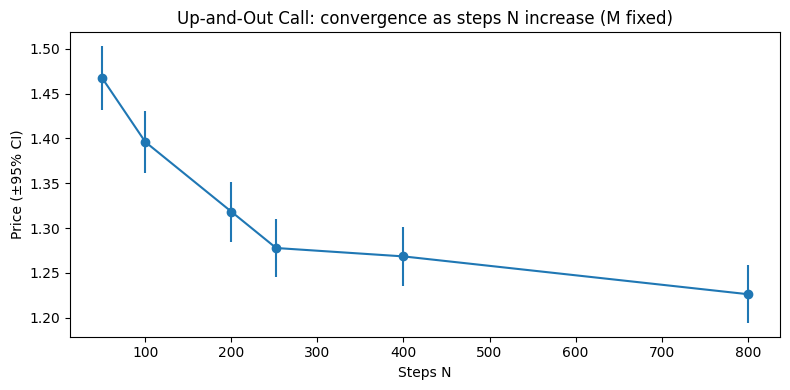

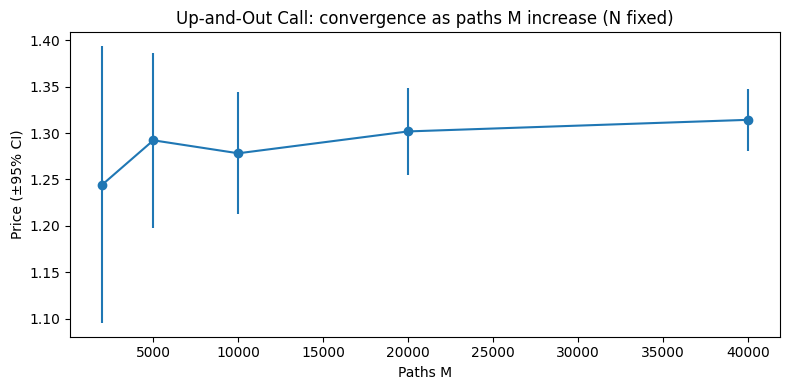

In [18]:
S0, K, r, q, sigma, T = 100.0, 100.0, 0.03, 0.00, 0.2, 1.0
H = 120.0

# Convergence in steps (fix M)
M_fix = 40000
steps_list = [50, 100, 200, 252, 400, 800]
est_steps, ci_steps = [], []
for N in steps_list:
    p, se = barrier_option_mc(S0, K, r, q, sigma, T, N, M_fix, True, "up", H, "out", seed=1)
    est_steps.append(p); ci_steps.append(1.96*se)

plt.figure()
plt.errorbar(steps_list, est_steps, yerr=ci_steps, fmt='o-')
plt.title("Up-and-Out Call: convergence as steps N increase (M fixed)")
plt.xlabel("Steps N")
plt.ylabel("Price (±95% CI)")
plt.tight_layout()
plt.show()

# Convergence in paths (fix N)
N_fix = 252
paths_list = [2000, 5000, 10000, 20000, 40000]
est_paths, ci_paths = [], []
for M in paths_list:
    p, se = barrier_option_mc(S0, K, r, q, sigma, T, N_fix, M, True, "up", H, "out", seed=2)
    est_paths.append(p); ci_paths.append(1.96*se)

plt.figure()
plt.errorbar(paths_list, est_paths, yerr=ci_paths, fmt='o-')
plt.title("Up-and-Out Call: convergence as paths M increase (N fixed)")
plt.xlabel("Paths M")
plt.ylabel("Price (±95% CI)")
plt.tight_layout()
plt.show()